In [288]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
from sklearn.model_selection import train_test_split

import math

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

import patsy

In [289]:
# Current script
current_path = os.getcwd()

# Add utils folder to sys path 
sys.path.append(os.path.join(current_path, "utils"))

# Import the prewritten helper functions
from py_helper_functions import *

# DATA

In [290]:
# Read the data
data = pd.read_csv("https://raw.githubusercontent.com/00Dabide/DA3-Assignment-3/main/cs_bisnode_panel.csv")


data = data.query("year != 2016")
data = data.query("year >= 2014")

# Label Engineering

In [291]:
pd.set_option("float_format", "{:.5f}".format)

In [292]:
#Alive in 2014: sales is positive (>0) and not NA, in 2014
data["status_alive2014"] = ((data["sales"] > 0) & (data["sales"].isna() == False) & (data["year"] == 2014)).astype(int)

#Alive in 2015: sales is positive (>0) and not NA, in 2015
data["status_alive2015"] = ((data["sales"] > 0) & (data["sales"].isna() == False) & (data["year"] == 2015)).astype(int)

In [293]:
#Your definition of default should be the following:
# – Existed in 2014 (sales > 0)(status_alive2014 is 1), but did not exists in 2015 (sales is 0 or missing)(status_alive2015 is not 1)
data["default"] = ((data["status_alive2014"] == 1) & (data.groupby("comp_id")["status_alive2015"].shift(-1) != 1)).astype(int)

In [294]:
# drop variables with many NAs
data = data.drop(
   columns=["COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"]
)

In [295]:
# change negative sales values into 1
data["sales"] = np.where(
    data["sales"] < 0, 1, data["sales"])

In [296]:
# Create log sales, sales in millions, log sales in million

data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),  # NaN remain NaN
    sales_mil=data["sales"] / 1000000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1000000),
        (np.where(data["sales"].isna(), np.nan, 0)),
    ),
)

In [297]:
# 1 year difference in log sales million
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")[
    "sales_mil_log"
].shift(1)

In [298]:
# replace age 0 for new firms + add dummy to capture it
data["age"] = np.where(
    data["year"] - data["founded_year"] < 0, 0, data["year"] - data["founded_year"]
)

data["new"] = np.where(
    ((data["age"] <= 1) | (data["balsheet_notfullyear"] == 1)),
    1,
    (np.where(data["age"].isna(), np.nan, 0)),
)

In [299]:
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, np.where(data["new"].isna(), np.nan, data["d1_sales_mil_log"])
)

data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)

# Feature Engineering

In [300]:
# change some industry category codes
# data = data.loc[data["ind2"] == 26]

In [301]:
# Firm characteristics
# age squared
data["age2"] = data["age"] ** 2

# foreign management if more than 50% is foreign
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1, np.where(data["foreign"].isna(), np.nan, 0)
)

# to category
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")

In [302]:
###########################################################
# look at more financial variables, create ratios
###########################################################

# assets can't be negative. Change them to 0 and add a flag.
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"] < 0)
        | (data["curr_assets"] < 0)
        | (data["fixed_assets"] < 0)
    ),
    1,
    0,
)
data["flag_asset_problem"] = np.where(
    (
        (data["intang_assets"].isna())
        | (data["curr_assets"].isna())
        | (data["fixed_assets"].isna())
    ),
    np.nan,
    data["flag_asset_problem"],
)
data.groupby("flag_asset_problem").count()["comp_id"]

flag_asset_problem
0.00000    55609
1.00000       28
Name: comp_id, dtype: int64

In [303]:
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"] = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"] = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])

In [304]:
# generate total assets
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)
data["total_assets_bs"].describe()

count        55637.00000
mean        520295.83449
std       12285952.84405
min              0.00000
25%           5248.14819
50%          20629.62933
75%          90929.62793
max     2706025809.40723
Name: total_assets_bs, dtype: float64

In [305]:
pl_names = [
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "inc_bef_tax",
    "inventories",
    "material_exp",
    "profit_loss_year",
    "personnel_exp",
]
bs_names = [
    "intang_assets",
    "curr_liab",
    "fixed_assets",
    "liq_assets",
    "curr_assets",
    "share_eq",
    "subscribed_cap",
    "tang_assets",
]

# divide all pl_names elements by sales and create new column for it
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)

# divide all bs_names elements by total_assets_bs and create new column for it
data[[col + "_bs" for col in bs_names]] = (
    data[bs_names]
    .div(data["total_assets_bs"], axis="index")
    .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
)
# get Nan values where total_assets_bs is NaN
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )

In [306]:
########################################################################
# creating flags, and winsorizing tails
########################################################################

# Variables that represent accounting items that cannot be negative (e.g. materials)
zero = [
    "extra_exp_pl",
    "extra_inc_pl",
    "inventories_pl",
    "material_exp_pl",
    "personnel_exp_pl",
    "curr_liab_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
]

data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)
data[[col for col in zero]] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)

In [307]:
# for vars that could be any, but are mostly between -1 and 1
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)
data[[col for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)

# dropping flags with no variation
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[(data[flag_columns].std() == 0)].index, axis=1
)

In [308]:
########################################################################
# additional
# including some imputation
########################################################################

# CEO age
data["ceo_age"] = data["year"] - data["birth_year"]
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=(data["ceo_age"].isna()).astype(int),
)


data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)

In [309]:
# number emp, very noisy measure
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = (data["labor_avg"].isna()).astype(int)

In [310]:
data = data.drop(["labor_avg"], axis=1)

In [311]:
# create category type variables
data["urban_m"] = data["urban_m"].astype("category")
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])

In [312]:
########################################################################
# sales
########################################################################
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2

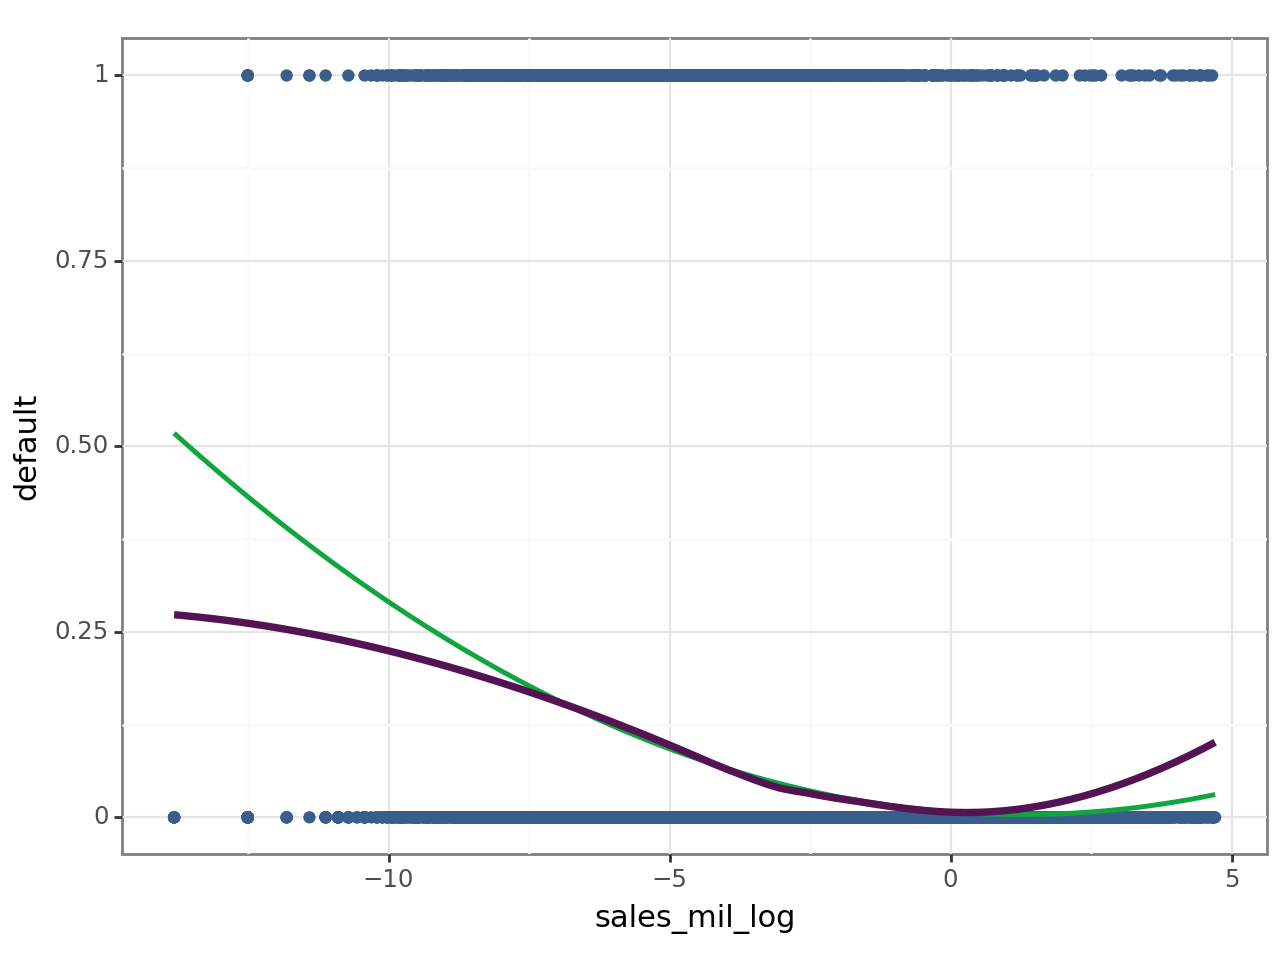

<Figure Size: (640 x 480)>

In [313]:
(
    ggplot(data, aes(x="sales_mil_log", y="default"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color=color[1], se=False)
    + geom_smooth(method="loess", color=color[2], se=False, size=1.5, span=0.9)
    + labs(x="sales_mil_log", y="default")
    + theme_bw()
)

In [314]:
# Linear regressions
ols_s = smf.ols("default ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     1291.
Date:                Wed, 28 Feb 2024   Prob (F-statistic):               0.00
Time:                        14:29:11   Log-Likelihood:                 10188.
No. Observations:               55530   AIC:                        -2.037e+04
Df Residuals:                   55527   BIC:                        -2.034e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0073      0.001  

In [315]:
########################################################################
# sales change
########################################################################
# Note: graphs not in book

# lowess
data["d1_sales_mil_log"].describe()

count   55657.00000
mean        0.04596
std         0.99203
min       -12.50618
25%         0.00000
50%         0.00000
75%         0.00000
max        13.81551
Name: d1_sales_mil_log, dtype: float64

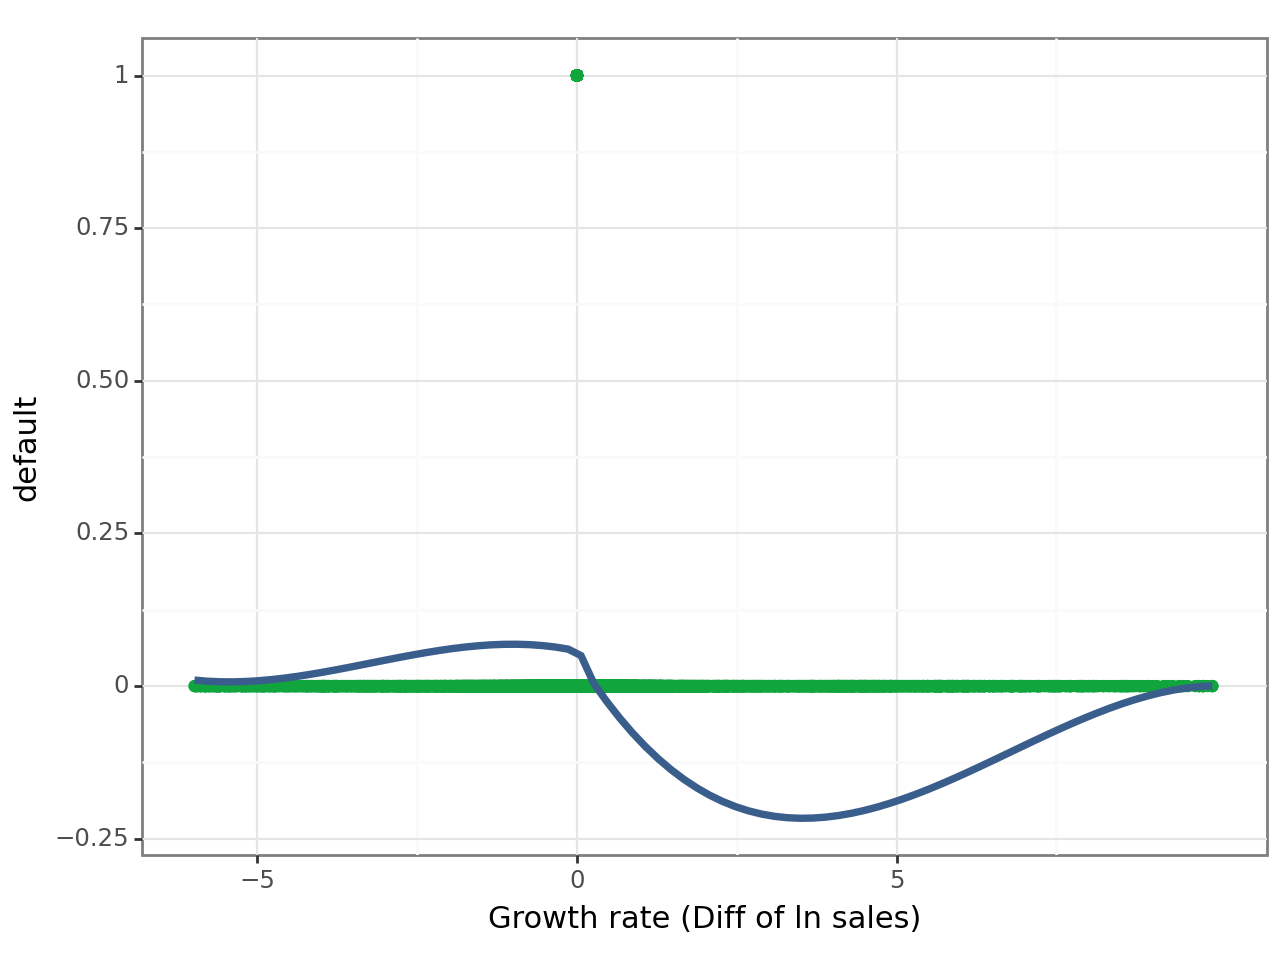

<Figure Size: (640 x 480)>

In [316]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-6, 10), breaks=seq(-5, 10, by=5))
    + theme_bw()
)

In [317]:
# generate variables ---------------------------------------------------

data["flag_low_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] < -1.5, 1, 0)
data["flag_high_d1_sales_mil_log"] = np.where(data["d1_sales_mil_log"] > 1.5, 1, 0)
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5,
    -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"]),
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2

In [318]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

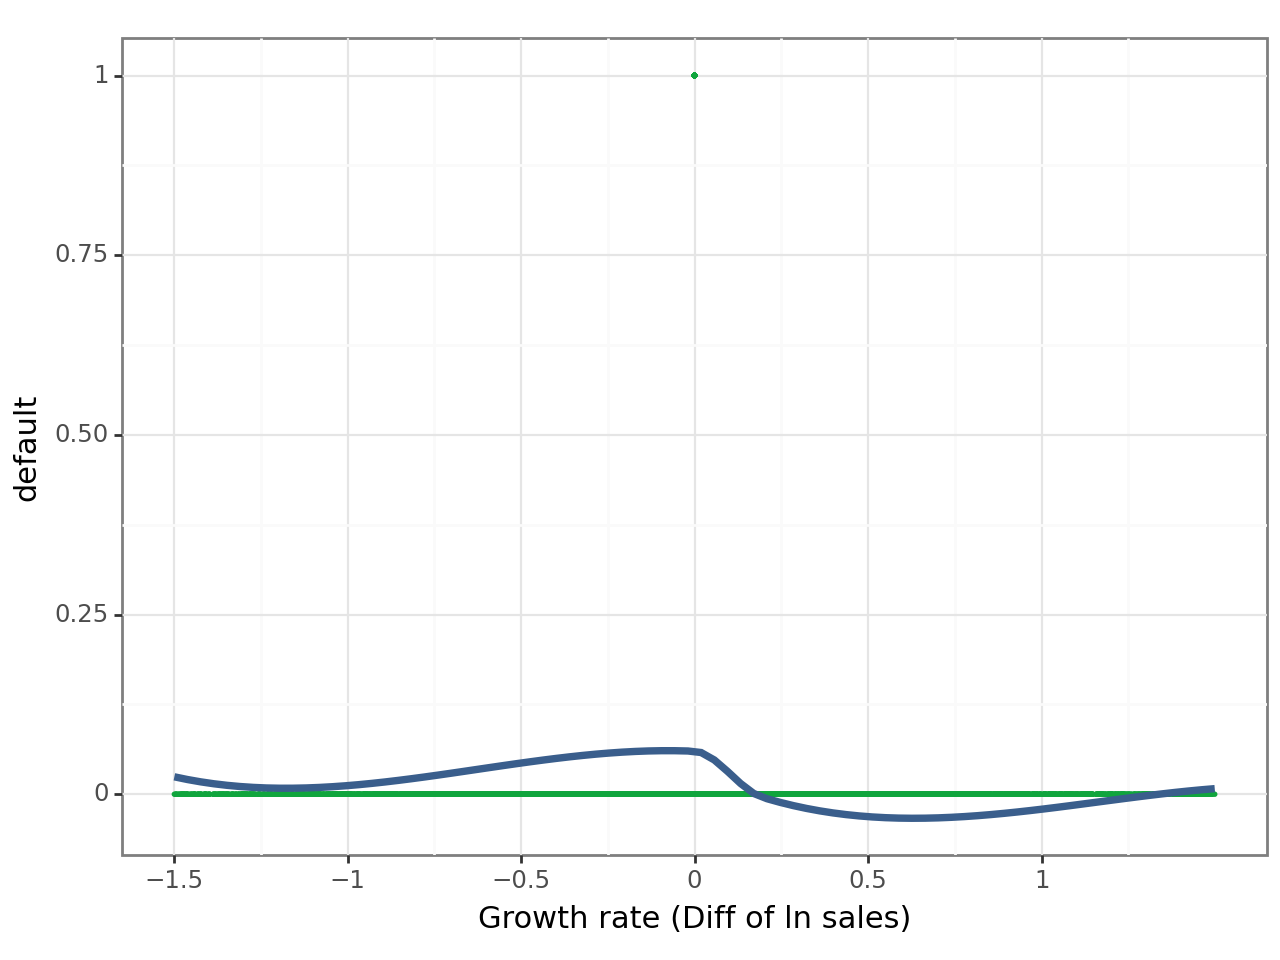

<Figure Size: (640 x 480)>

In [319]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(size=0.1, color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-1.5, 1.5), breaks=seq(-1.5, 1.5, by=0.5))
    + theme_bw()
)

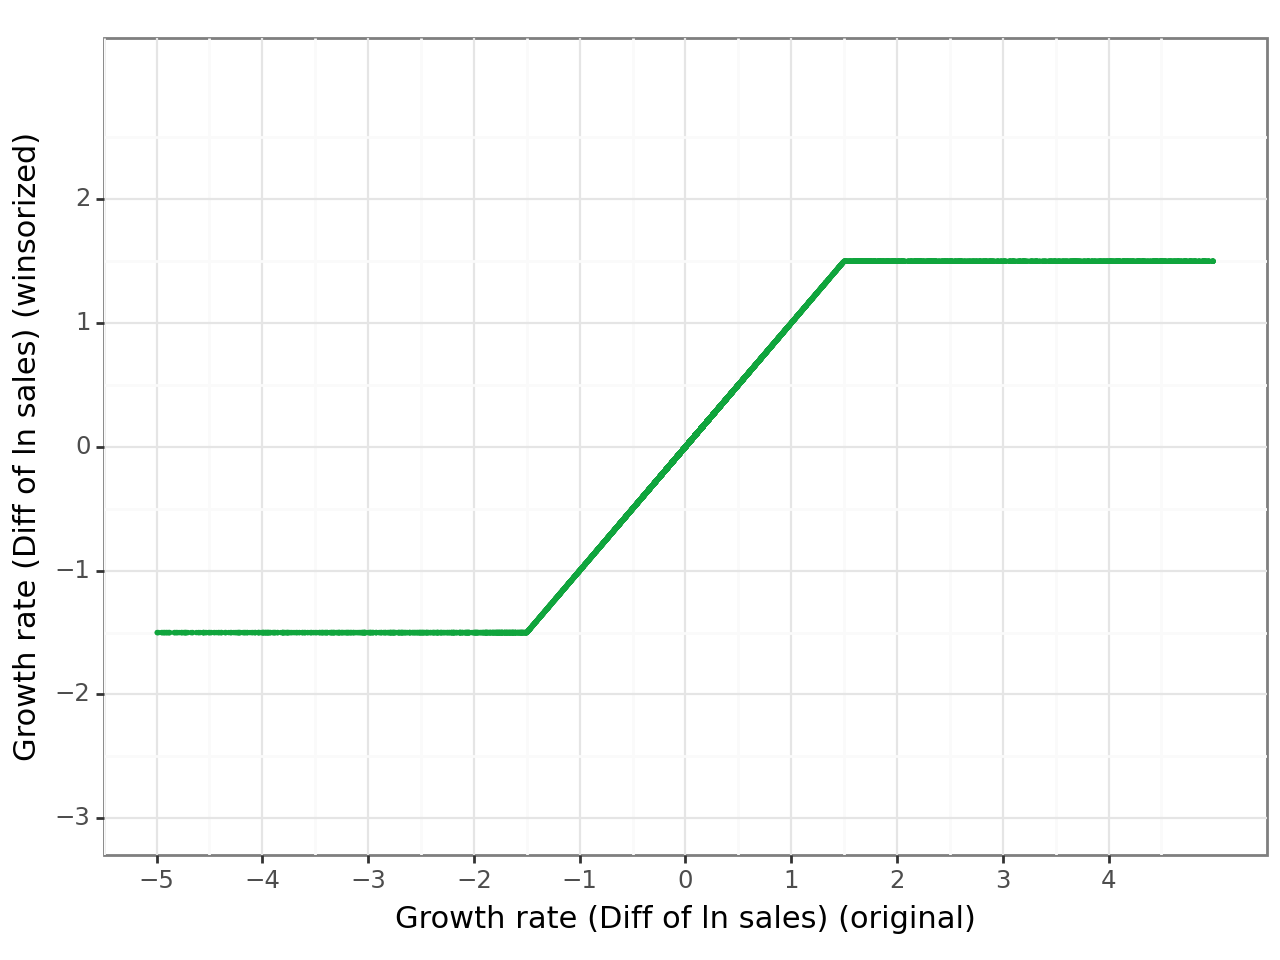

<Figure Size: (640 x 480)>

In [320]:
(
    ggplot(data, aes(x="d1_sales_mil_log", y="d1_sales_mil_log_mod"))
    + geom_point(size=0.1, color=color[1])
    + labs(
        x="Growth rate (Diff of ln sales) (original)",
        y="Growth rate (Diff of ln sales) (winsorized)",
    )
    + scale_x_continuous(limits=(-5, 5), breaks=seq(-5, 5, by=1))
    + scale_y_continuous(limits=(-3, 3), breaks=seq(-3, 3, by=1))
    + theme_bw()
)

In [321]:
# Fill NAs

data["liq_assets_bs"] = data["liq_assets_bs"].fillna(0)
data["foreign"] = data["foreign"].fillna(0)
data["material_exp_pl"] = data["material_exp_pl"].fillna(0)
data["foreign_management"] = data["foreign_management"].fillna(0)

# Holdout Sample

In [322]:
data_holdout = data

# Existed in 2014 (sales > 0), but did not exists in 2015 (sales is 0 or missing)
Exist14 = data.loc[(data["year"] == 2014) & (data["sales"] > 0)]
Exist15 = data.loc[(data["year"] == 2015) & (data["sales"].isin([0, np.nan]))]

data_holdout = Exist14[~Exist14.index.isin(Exist15.index)]

# between 1000 and 10 million
data_holdout = data_holdout.loc[(data_holdout["sales"] > 1000) & (data_holdout["sales"] < 10000000)]

# ind2 == 26
data_holdout = data_holdout.loc[data_holdout["ind2"] == 26]

data_train = data[~data.index.isin(data_holdout.index)]

data_holdout["sales"].describe()

count      1037.00000
mean     490202.21793
std     1154087.41432
min        1070.37036
25%       21766.66602
50%       72700.00000
75%      333888.87500
max     9576485.00000
Name: sales, dtype: float64

In [323]:
data_holdout["default"].value_counts()

default
0    981
1     56
Name: count, dtype: int64

In [324]:
data_train = data_train.reset_index()
data_train = data_train.drop("index", axis = 1)

# Helper Functions

In [325]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
def create_coef_matrix(X, model):
    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns),pd.DataFrame(model.coef_.flatten())], axis = 1
    )
    coef_matrix.columns = ['variable', 'coefficient']
    coef_matrix.iloc[-1] = ['Intercept', model.intercept_.flatten()[0]]
    return coef_matrix

def cv_summary(lambdas, C_values, model):
    d = {'lambdas': lambdas, 'C_values': C_values, 'mean_cv_score': model.scores_[1].mean(axis = 0)}
    return(pd.DataFrame(data=d))

def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({
        'fpr': fpr,
        'tpr': tpr,
        'thresholds': thresholds
    })
    
    plot = ggplot(all_coords, aes(x = 'fpr', y = 'tpr')) \
        + geom_line(color=color[0], size = 0.7) \
        + geom_area(position = 'identity', fill = 'mediumaquamarine', alpha = 0.3) \
        + xlab("False Positive Rate (1-Specifity)") \
        + ylab("True Positive Rate (Sensitivity)") \
        + geom_abline(intercept = 0, slope = 1,  linetype = "dotted", color = "black") \
        + scale_y_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0, 0.01)) \
        + scale_x_continuous(limits = (0, 1), breaks = seq(0, 1, .1), expand = (0.01, 0)) \
        + theme_bw()
    return(plot)

def sigmoid_array(x):
    return(1 / (1 + np.exp(-x)))

def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold,param_index,:]
    return(sigmoid_array(np.dot(X, np.transpose(fold_coef)[:-1]) +  np.transpose(fold_coef)[-1]))

def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy['loss'] = (all_coords_copy.false_pos*FP + all_coords_copy.false_neg*FN)/all_coords_copy.n
    
    t = optimal_threshold
    l = curr_exp_loss
    
    plot = ggplot(all_coords_copy, aes(x = 'thresholds', y = 'loss')) + \
        geom_line(color=color[0], size=0.7) + \
        scale_x_continuous(breaks = seq(0, 1.1, by = 0.1)) + \
        coord_cartesian(xlim=(0,1))+ \
        geom_vline(xintercept = t , color = color[0] ) + \
        annotate(geom = "text", x = t - 0.01, y= max(all_coords_copy.loss) - 0.4,
                 label="best threshold: " + str(round(t,2)),
                 colour=color[1], angle=90, size = 7) +\
        annotate(geom = "text", x = t + 0.06, y= l,\
                 label= str(round(l, 2)), size = 7) +\
        theme_bw()
    return(plot)


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy['sp'] = all_coords_copy.true_neg/all_coords_copy.neg
    all_coords_copy['se'] = all_coords_copy.true_pos/all_coords_copy.pos
    
    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = ggplot(all_coords_copy, aes(x = 'sp', y = 'se')) +\
        geom_line(color=color[0], size=0.7) +\
        scale_y_continuous(breaks = seq(0, 1.1, by = 0.1)) +\
        scale_x_reverse(breaks = seq(0, 1.1, by = 0.1)) +\
        geom_point(data = pd.DataFrame({'sp': [sp], 'se': [se]})) +\
        annotate(geom = "text", x = sp, y = se + 0.03,
                 label = str(round(sp, 2)) + ', ' + str(round(se, 2)), size = 7) +\
        theme_bw()
    return(plot)

# Variable sets

In [326]:
rawvars = ["curr_assets", "curr_liab", "extra_exp", "extra_inc", "extra_profit_loss", "fixed_assets",
              "inc_bef_tax", "intang_assets", "inventories", "liq_assets", "material_exp", "personnel_exp",
              "profit_loss_year", "sales", "share_eq", "subscribed_cap"]
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = ["total_assets_bs", "fixed_assets_bs", "liq_assets_bs", "curr_assets_bs",
            "share_eq_bs", "subscribed_cap_bs", "intang_assets_bs", "extra_exp_pl",
            "extra_inc_pl", "extra_profit_loss_pl", "inc_bef_tax_pl", "inventories_pl",
            "material_exp_pl", "profit_loss_year_pl", "personnel_exp_pl"]
engvar2 = ["extra_profit_loss_pl_quad", "inc_bef_tax_pl_quad",
             "profit_loss_year_pl_quad", "share_eq_bs_quad"]
engvar3 = []
for col in data_train.columns:
    if col.endswith('flag_low') or col.endswith('flag_high') or col.endswith('flag_error') or col.endswith('flag_zero'):
        engvar3.append(col)


d1 =  ["d1_sales_mil_log_mod", "d1_sales_mil_log_mod_sq",
         "flag_low_d1_sales_mil_log", "flag_high_d1_sales_mil_log"]
hr = ["female", "ceo_age", "flag_high_ceo_age", "flag_low_ceo_age",
        "flag_miss_ceo_age", "ceo_count", "labor_avg_mod",
        "flag_miss_labor_avg", "foreign_management"]

In [327]:
m_region_locmat = patsy.dmatrix("0 + C(m_region_loc)",data, return_type="dataframe")
m_region_locmat = m_region_locmat.drop(['C(m_region_loc)[Central]'], axis=1)

In [328]:
urban_mmat = patsy.dmatrix("0 + C(urban_m)",data, return_type="dataframe")
urban_mmat = urban_mmat.drop(['C(urban_m)[1]'], axis=1)

In [329]:
# Define rfvars for RF (no interactions, no modified features)
rfvars  = pd.concat([data[["sales_mil", "d1_sales_mil_log"] + rawvars + hr + qualityvars]], axis=1)

In [330]:
# Define X1
basevars = data[["sales_mil_log", "sales_mil_log_sq", "d1_sales_mil_log_mod", "profit_loss_year_pl"]]
X1 = pd.concat([basevars], axis=1)

# Define X2
X2additional_vars = data[["fixed_assets_bs", "share_eq_bs","curr_liab_bs", "curr_liab_bs_flag_high", \
                          "curr_liab_bs_flag_error",  "age", "foreign_management"]]
X2 = pd.concat([X1, X2additional_vars], axis=1)

# Define X3
firm = pd.concat([data[["age", "age2", "new"]], m_region_locmat, urban_mmat], axis=1)
X3 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1], firm], axis=1)

# Define X4
X4 = pd.concat([data[["sales_mil_log", "sales_mil_log_sq"] + engvar + d1 \
                                 + engvar2 + engvar3 + hr + qualityvars], firm], axis=1)

In [331]:
y = data_train['default']

In [332]:
index_train, index_holdout= train_test_split(
    data_train.index.values, train_size=0.8, random_state=42)

y_train = y.iloc[index_train]
y_holdout = y.iloc[index_holdout]

# Random Forest

In [333]:
rfvars_train = rfvars.iloc[index_train]
rfvars_holdout = rfvars.iloc[index_holdout]

In [334]:
rfvars_train.columns

Index(['sales_mil', 'd1_sales_mil_log', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss', 'fixed_assets',
       'inc_bef_tax', 'intang_assets', 'inventories', 'liq_assets',
       'material_exp', 'personnel_exp', 'profit_loss_year', 'sales',
       'share_eq', 'subscribed_cap', 'female', 'ceo_age', 'flag_high_ceo_age',
       'flag_low_ceo_age', 'flag_miss_ceo_age', 'ceo_count', 'labor_avg_mod',
       'flag_miss_labor_avg', 'foreign_management', 'balsheet_flag',
       'balsheet_length', 'balsheet_notfullyear'],
      dtype='object')

<Figure size 640x480 with 0 Axes>

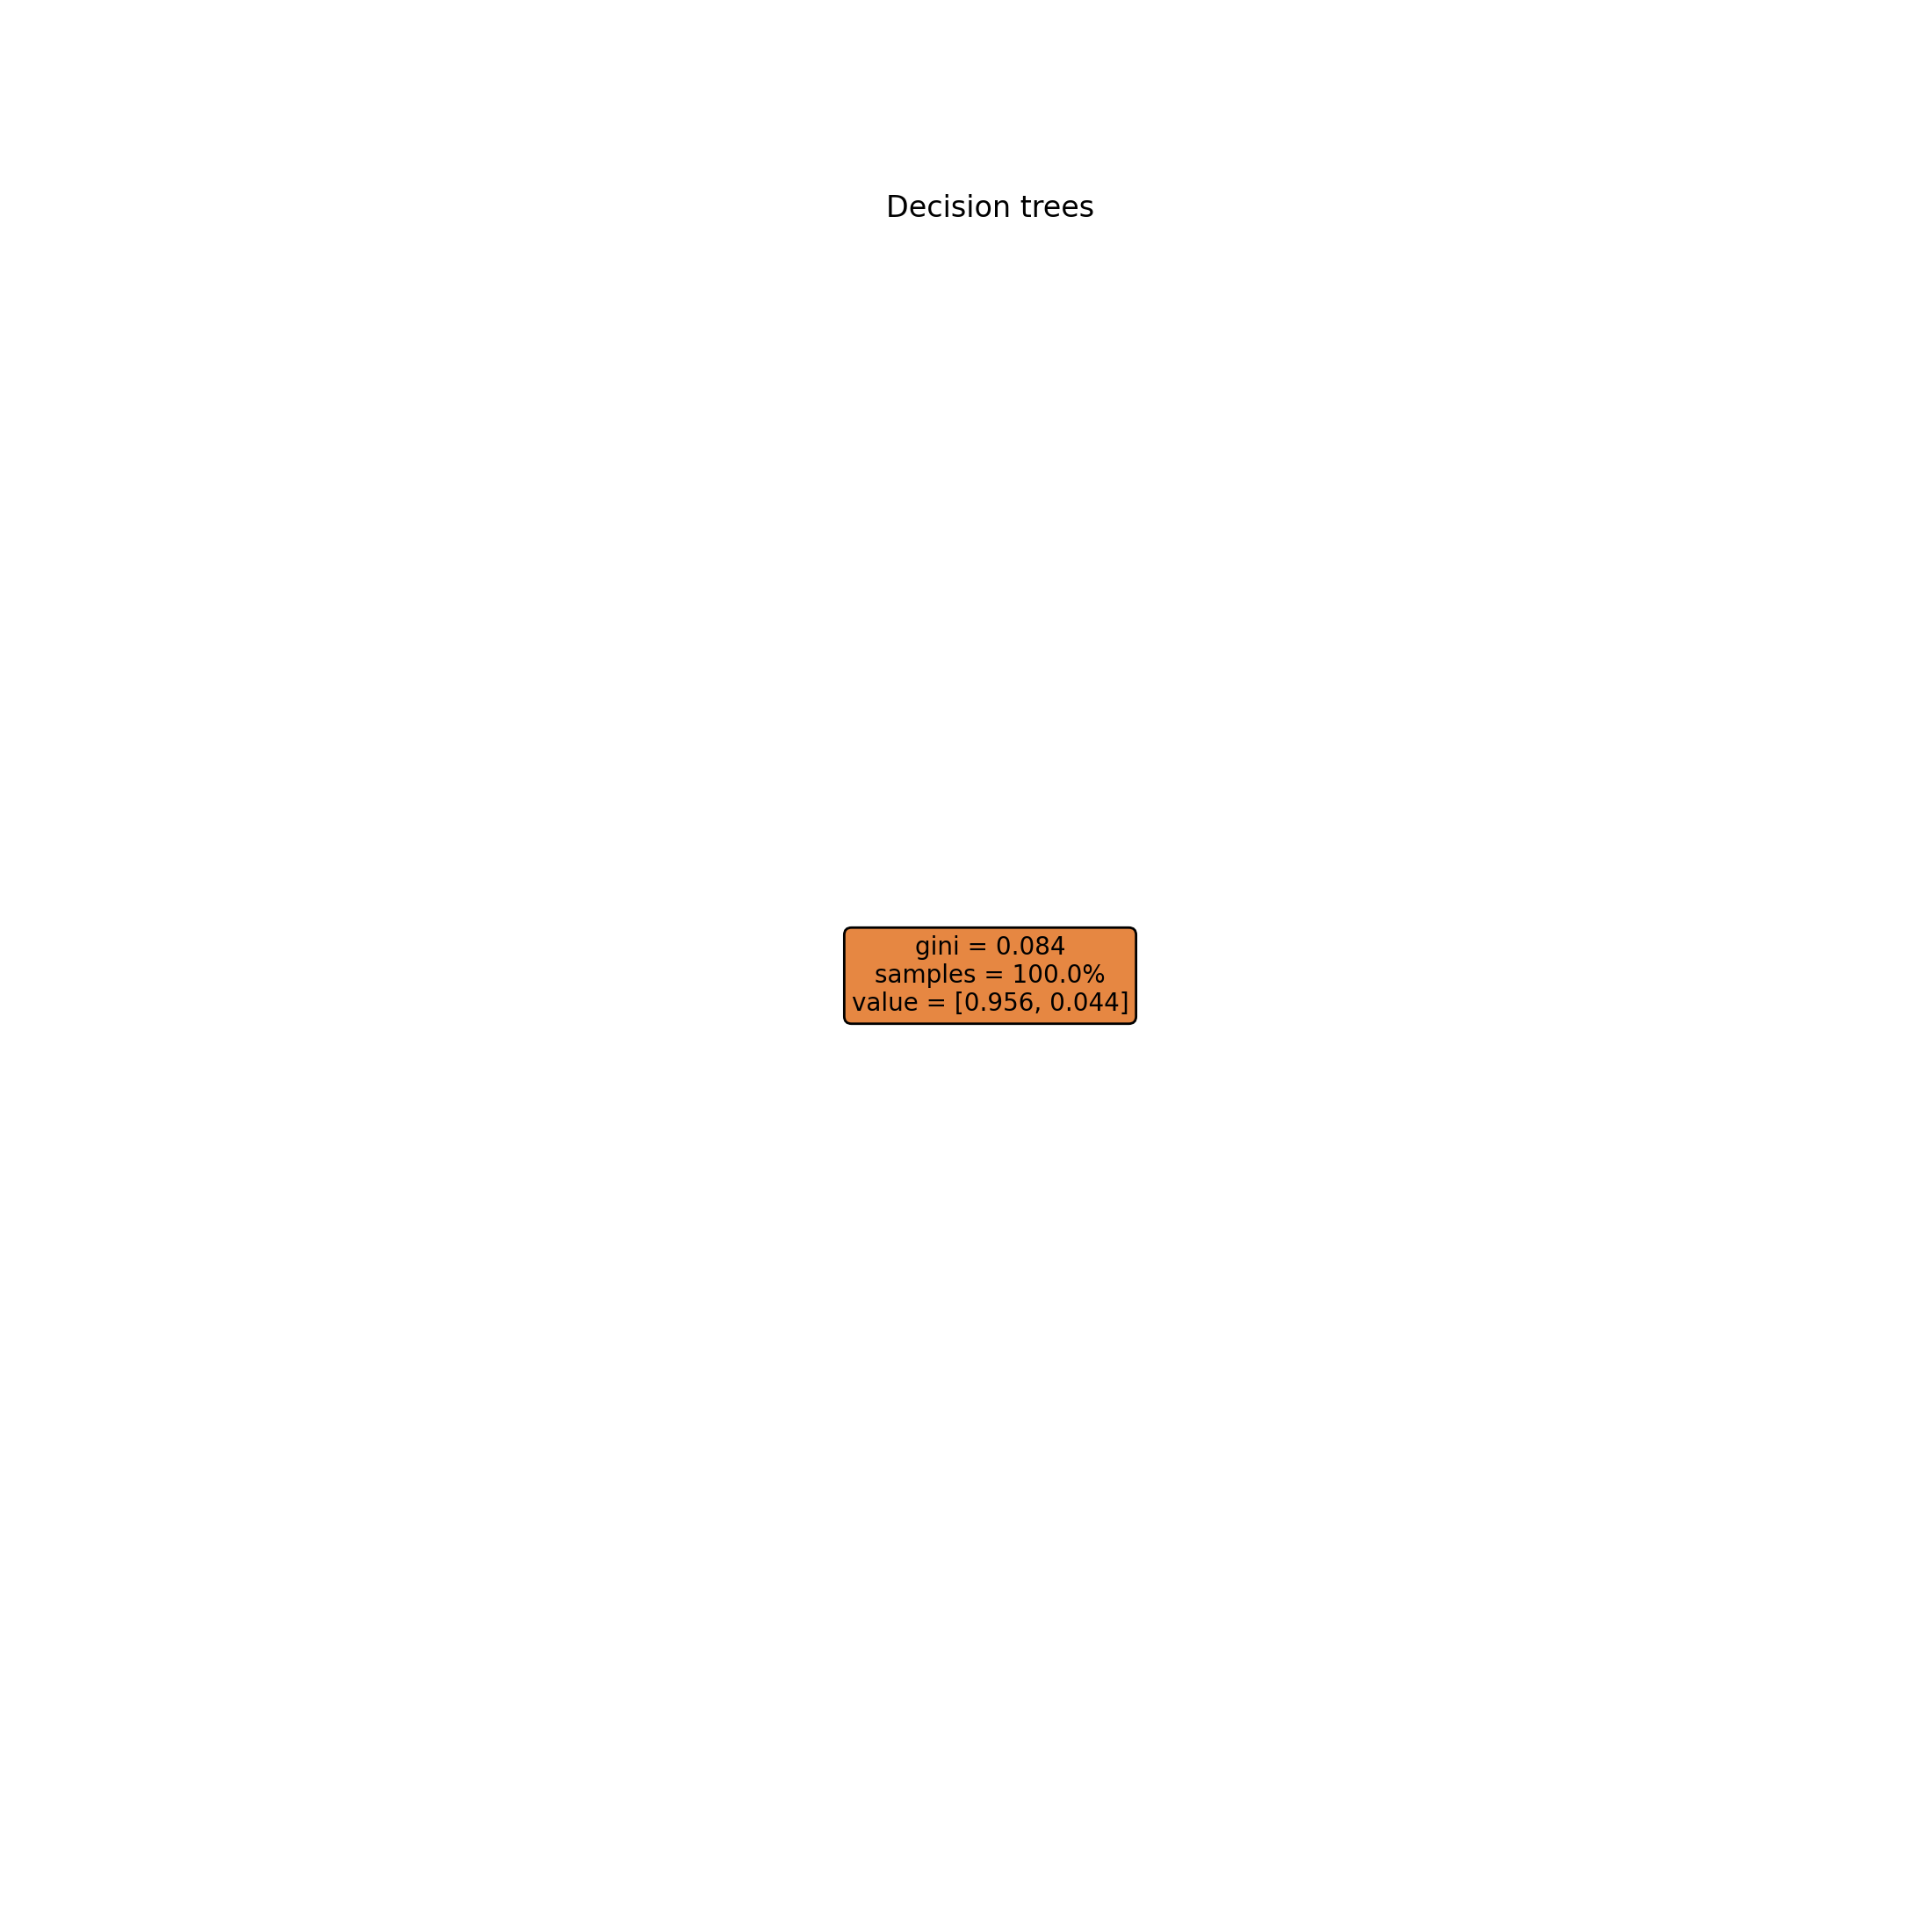

CPU times: total: 359 ms
Wall time: 353 ms


In [338]:
%%time 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

data_for_graph = rfvars_train[['sales_mil','profit_loss_year','foreign_management']]
rf_for_graph = DecisionTreeClassifier(
    ccp_alpha=0.0028, 
    min_samples_leaf=100, 
    max_depth=3, 
    random_state=41).fit(
    data_for_graph, 
    y_train)

plt.figure()
plt.figure(figsize=(11,11))
plot_tree(rf_for_graph, 
          feature_names = data_for_graph.columns, 
          filled=True, 
          rounded=True, 
          proportion=True, 
          fontsize = 10)
plt.title("Decision trees")
plt.show() 

In [339]:
data_train["sales_mil"].describe()

count   54493.00000
mean        0.49427
std         3.84723
min         0.00000
25%         0.00198
50%         0.02854
75%         0.11941
max       110.74581
Name: sales_mil, dtype: float64

# Simple linear and logistic models

## Model x1

In [337]:
ols_modelx1 = LinearRegression().fit(X1, y)
regression_results(y, ols_modelx1.predict(X1))

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
create_coef_matrix(X1, ols_modelx1)

In [ ]:
glm_modelx1 = LogisticRegression(
    solver="newton-cg",max_iter=1000, penalty="none", random_state = 20240205).fit(X1, y)
regression_results(y, glm_modelx1.predict(X1))

In [ ]:
create_coef_matrix(X1, glm_modelx1)